In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

if not cv.useOptimized():
    cv.setUseOpitimized(True)

cv.useOptimized()

True

# Exercise 1

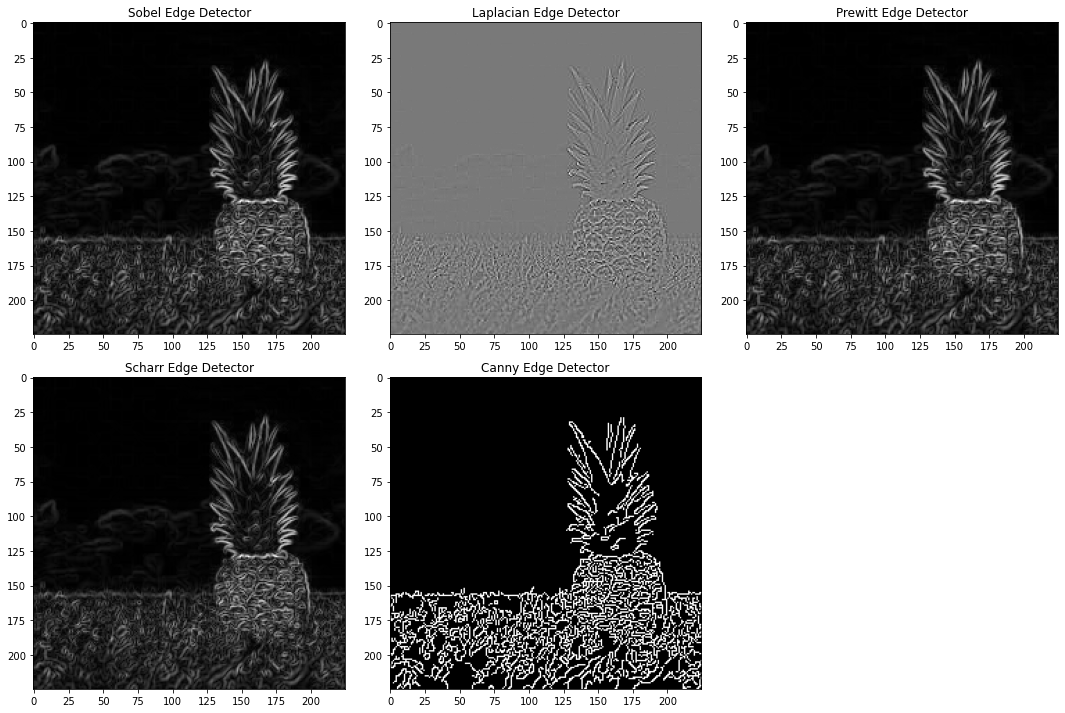

In [18]:
img = cv.imread("images/pineapple.jfif", 0)

# Apply Sobel edge detector
sobel_x = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=3)
sobel_y = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=3)
sobel_edges = cv.magnitude(sobel_x, sobel_y) #combine sobel x and y

# Apply Laplacian edge detector
laplacian_edges = cv.Laplacian(img, cv.CV_32F)

# Apply Prewitt edge detector
prewitt_x = cv.filter2D(img, cv.CV_32F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
prewitt_y = cv.filter2D(img, cv.CV_32F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
prewitt_edges = cv.magnitude(prewitt_x, prewitt_y) #combine prewitt x and y

# Apply Scharr edge detector
scharr_x = cv.Scharr(img, cv.CV_32F, 1, 0)
scharr_y = cv.Scharr(img, cv.CV_32F, 0, 1)
scharr_edges = cv.magnitude(scharr_x, scharr_y)

# Apply Canny edge detector
canny_edges = cv.Canny(img, 100, 300)

# Display the results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel Edge Detector')

plt.subplot(2, 3, 2)
plt.imshow(laplacian_edges, cmap='gray')
plt.title('Laplacian Edge Detector')

plt.subplot(2, 3, 3)
plt.imshow(prewitt_edges, cmap='gray')
plt.title('Prewitt Edge Detector')

plt.subplot(2, 3, 4)
plt.imshow(scharr_edges, cmap='gray')
plt.title('Scharr Edge Detector')

plt.subplot(2, 3, 5)
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edge Detector')

plt.tight_layout()
plt.show()


Sobel Edge Detector: sobel x detects vertical edges, sobel y detects horizontal edges. Combining both sobels highlights the edges in the image with thicker line.

Laplacian Edge Detector:highlight changes in intensity.Messy.

Prewitt Edge Detector: similar to Sobel but uses different kernel. Performance is sensitive to noise.

Scharr Edge Detector: more advanced version of Sobel, provide better edge detection for edges that are diagonal (45degree edges). Capture finer details of edges.

Canny Edge Detector: map and provides clean and well-defined edges with thin lines. Minimal noise.

# Exercise 2

In [22]:
kernel = np.ones((3, 3), dtype=np.uint8)
fixed_width = min_area = 300

# Load the image
img = cv.imread("images/electronic.jfif")

blur = cv.GaussianBlur(img, (5, 5), 0)
img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)

whiteLow = (0, 0, 200)
whiteHigh = (179, 30, 255)

mask = cv.inRange(img_hsv, whiteLow, whiteHigh)
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)

#find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
bbs = []
    
for c in contours:
    area = cv.contourArea(c)
    if area > min_area:
        bb = cv.boundingRect(c)
        bbs.append(bb)
            
for bb in bbs:
    x, y, w, h = bb
    cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
show_img("bounding box", img)

# Exercise 3

In [24]:
# Load the image
image = cv.imread("images/clock.jpg")
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply edge detection (Canny)
edges = cv.Canny(gray_image, threshold1=50, threshold2=150)

# Find contours in the edge-detected image
contours, _ = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Iterate through contours and find the object of interest (clock)
for contour in contours:
    # Analyze contour properties (e.g., area, aspect ratio, etc.)
    x, y, w, h = cv.boundingRect(contour)
    contour_area = cv.contourArea(contour)
    aspect_ratio = float(w) / h
    
    # Customize the conditions based on your image and object properties
    if contour_area > 100 and aspect_ratio > 0.33:
        # Draw a bounding box around the object of interest
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
cv.imshow('Isolated Clock', image)
cv.waitKey(0)
cv.destroyAllWindows()


In [23]:
def auto_canny(img, method, sigma=0.33):
    """Args:
    img: source grayscale image
    method: median, otsu and triangle
    sigma: 0.33 (default best)"""
    
    if method == "median":
        Th = np.median(img)
    
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    else:
        raise Exception("Method specified unavailable")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh)

In [33]:
img = cv.imread("images/clock.jpg")

factor = 300 / img.shape[1] #scale factor = output width /image width
img = cv.resize(img, None, fx=factor, fy = factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method="median")

# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# sort contour with regard to area in descending order and take the first 5
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
clock_contour = None
largest_area = 0

for c in contours:
    area = cv.contourArea(c)
    if area > largest_area:
        largest_area = area
        clock_contour = c
        
img_copy = img.copy()        
cv.drawContours(img_copy, [clock_contour], -1, (0, 255, 0), 2)

show_img("screen", img_copy)